**Music genre Classification on GTZAN dataset**


## **Feature Extraction of GTZAN dataset**

In [ ]:
# Import the python library
# Using librosa to extract the features
import librosa
import pandas as pd
import csv
import os
import numpy as np

In [ ]:
data = pd.read_csv('data.csv')
data = data.drop(['filename'],axis=1)

# Manualy drop the mfccs from 13 to 20 for training the model
data = data.drop(['zero_crossing_rate'],axis=1)
data = data.drop(['mfcc13'],axis=1)
data = data.drop(['mfcc14'],axis=1)
data = data.drop(['mfcc15'],axis=1)
data = data.drop(['mfcc16'],axis=1)
data = data.drop(['mfcc17'],axis=1)
data = data.drop(['mfcc18'],axis=1)
data = data.drop(['mfcc19'],axis=1)
data = data.drop(['mfcc20'],axis=1)

data.shape

(1000, 22)

# **Methods for applying algorithms**

Logistic Regression and SVC (Support Vector Classification)**bold text**

In [ ]:
from sklearn import linear_model
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.model_selection import GridSearchCV
import lightgbm as lgbm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from matplotlib import pyplot as plt 
from sklearn.externals import joblib
import seaborn as sn

genre_list = ["Blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

#Function to train the model using Logistic Regression
def log_reg_func(X_train, y_train, X_test, y_test, genre):
	logistic_classifier = linear_model.LogisticRegression(max_iter=1000)
	logistic_classifier.fit(X_train, y_train)
 
	logistic_predictions = logistic_classifier.predict(X_test)
	logistic_accuracy = accuracy_score(y_test, logistic_predictions)
 
	logistic_cm = confusion_matrix(y_test, logistic_predictions)
 
	print("Train set accuracy: {:.2f}".format(logistic_classifier.score(X_train, y_train)))
	print("Test set accuracy = " + str(logistic_accuracy))
	joblib.dump(logistic_classifier, 'model.pkl')
	plot_matrix(logistic_cm, "Confusion matrix of Logistic Regression", genre)
 
 #Function to plot the confusion matrix
def plot_matrix(cm, title, genre):
  df_cm = pd.DataFrame(cm, index = ["Blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
                  columns = ["Blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"])
  plt.figure(figsize = (10,7)),	plt.title(title)
  sn.heatmap(df_cm, annot=True, cmap="YlGnBu")
	

In [ ]:
linear_params = {
    "cls__C": [0.5, 1, 2, 5],
    "cls__kernel": ['linear'],
}

poly_params = {
    "cls__C": [0.5, 1, 2, 5],
    "cls__kernel": ['poly'],
}

rbf_params = {
    "cls__C": [0.5, 1, 2, 5],
    "cls__kernel": ['rbf'],
}

pipe_svm = Pipeline([
    ('scale', StandardScaler()),
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', svm.SVC())
])

#Function to train the model using SVM
def svm_model(params, X_train, y_train, X_test, y_test, title):
  svm = GridSearchCV(pipe_svm, params, scoring='accuracy', cv=5)
  svm.fit(X_train, y_train)
  svm_pred = svm.predict(X_test)

  train_accuracy = svm.score(X_train, y_train)
  test_accuracy = svm.score(X_test, y_test)
  print("Train set accuracy: {:.2f}".format(train_accuracy))
  print("Test set accuracy: {:.2f}".format(test_accuracy))

  svm_cm = confusion_matrix(y_test, svm_pred)

  plot_matrix(svm_cm, title, genre_list)

# **Training the datatset**

In [ ]:
# Scaling the dataset
# and Label encoding the label (genres)
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

In [ ]:
# Split the dataset with 70% for training set and 30% for test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

## KNeighborsClassifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

#Training Model using KNN
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)

train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)
print("Train set accuracy: {:.2f}".format(train_accuracy))
print("Test set accuracy: {:.2f}".format(test_accuracy))

Train set accuracy: 0.82
Test set accuracy: 0.60


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.8s finished


Train set accuracy: 0.78
Test set accuracy: 0.61
Best n_neighbors: 5


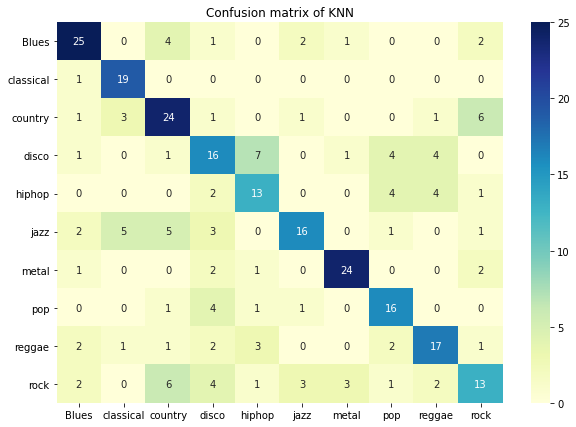

In [ ]:
# Apllying GridSearchCV to find the best k value
grid_params = {
    "n_neighbors": [1,3,5,7,9,11,13,15,17],
    "weights": ["uniform"],
    "metric": ["euclidean", "manhattan"]
}

grid_knn = GridSearchCV(KNeighborsClassifier(), grid_params, verbose=1,cv=5,n_jobs=-1)

grid_knn.fit(X_train, y_train)
knn_pred = grid_knn.predict(X_test)
print("Train set accuracy: {:.2f}".format(grid_knn.score(X_train, y_train)))
print("Test set accuracy: {:.2f}".format(accuracy_score(y_test, knn_pred)))
print('Best n_neighbors:', grid_knn.best_estimator_.get_params()['n_neighbors'])


#ploting the confusion matrix for KNN
grid_cm = pd.DataFrame(confusion_matrix(y_test, knn_pred), index = ["Blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
                  columns = ["Blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"])
plt.figure(figsize = (10,7))
plt.title("Confusion matrix of KNN")
sn.heatmap(grid_cm, annot=True, cmap="YlGnBu")

## Support Vector Classifier (SVC)

Train set accuracy: 0.70
Test set accuracy: 0.57


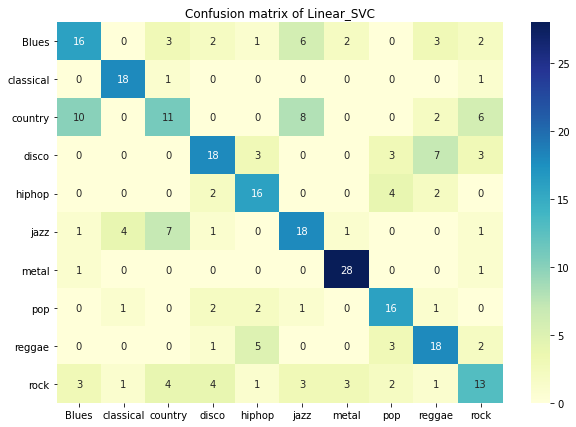

In [ ]:
svm_model(linear_params, X_train, y_train, X_test, y_test, "Confusion matrix of Linear_SVC")

Train set accuracy: 0.79
Test set accuracy: 0.59


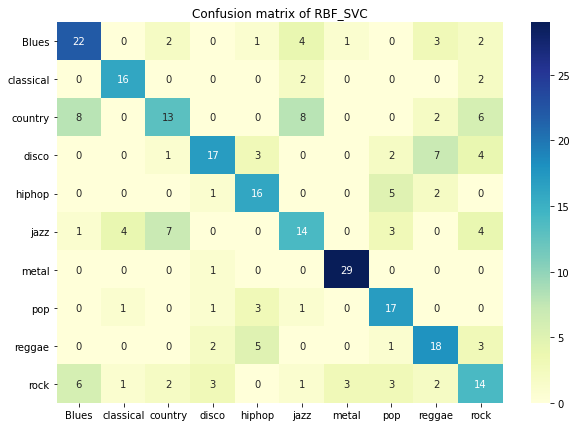

In [ ]:
svm_model(rbf_params, X_train, y_train, X_test, y_test, "Confusion matrix of RBF_SVC")

Train set accuracy: 0.83
Test set accuracy: 0.61


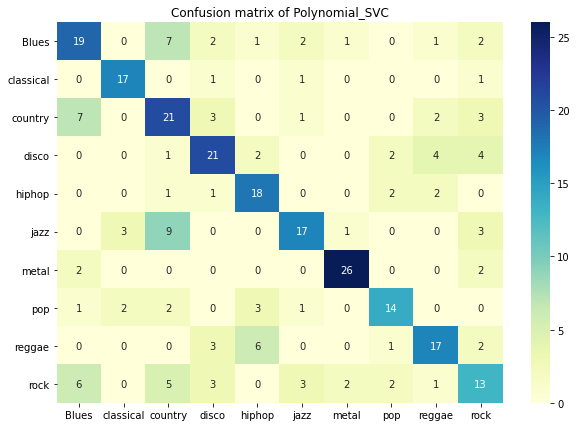

In [ ]:
svm_model(poly_params, X_train, y_train, X_test, y_test, "Confusion matrix of Polynomial_SVC")

## Logistic Regression

Train set accuracy: 0.76
Test set accuracy = 0.63


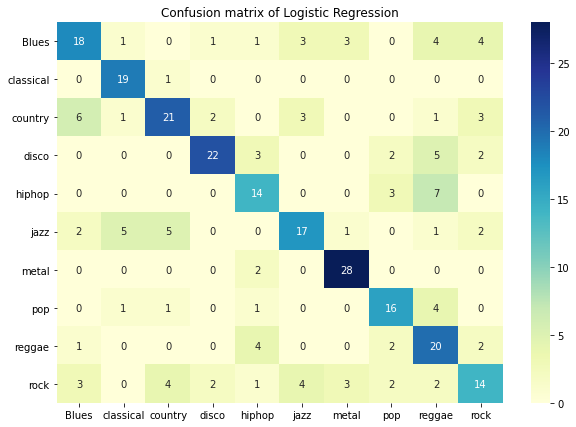

In [ ]:
log_reg_func(X_train, y_train, X_test, y_test, genre_list)

# **Training the Chromagram and MFCCs features**

## Chromagram

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train set accuracy: 0.27
Test set accuracy = 0.19666666666666666


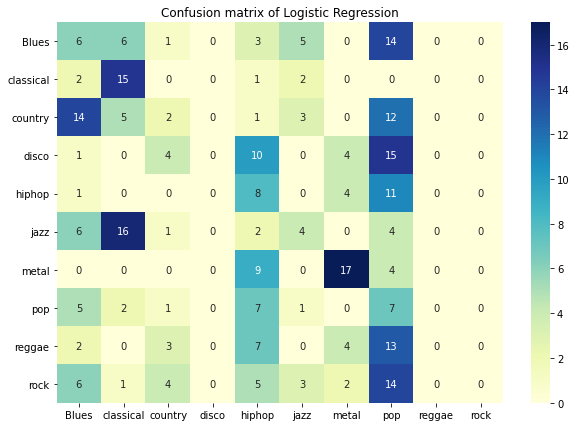

In [ ]:
#traing the model using only Chroma as feature

chroma = scaler.fit_transform(np.array(data.iloc[:,0]).reshape(-1,1))
chromaX_train, chromaX_test, chromaY_train, chromaY_test = train_test_split(chroma, y.reshape(-1,1), test_size=0.30, random_state=42)
log_reg_func(chromaX_train, chromaY_train, chromaX_test, chromaY_test, ["Blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"])

Train set accuracy: 0.27
Test set accuracy: 0.19


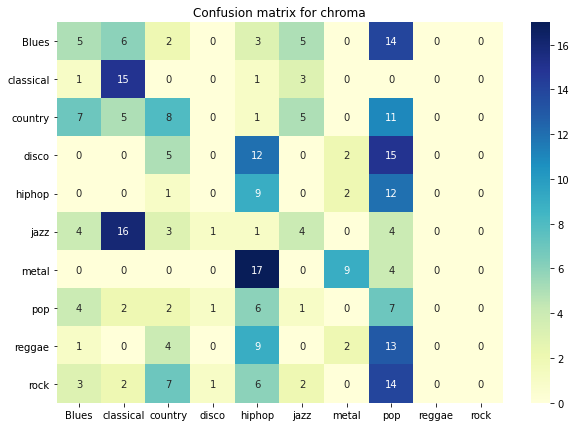

In [ ]:
# train the model with SVM using Linear kernal
svm_model(linear_params, chromaX_train, chromaY_train.ravel(), chromaX_test, chromaY_test, "Confusion matrix for chroma")

Train set accuracy: 0.30
Test set accuracy: 0.25


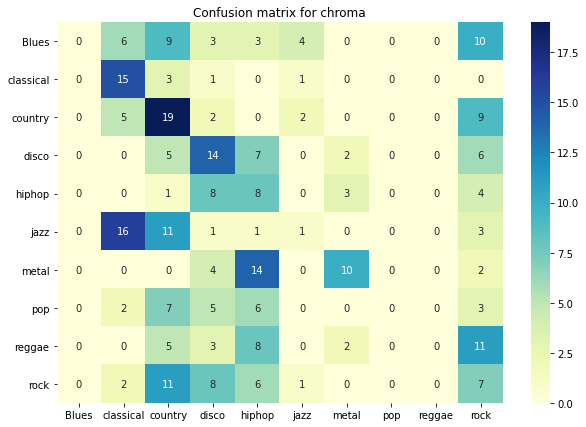

In [ ]:
# train the model with SVM using RBF kernal
svm_model(rbf_params, chromaX_train, chromaY_train.ravel(), chromaX_test, chromaY_test, "Confusion matrix for chroma")

Train set accuracy: 0.25
Test set accuracy: 0.18


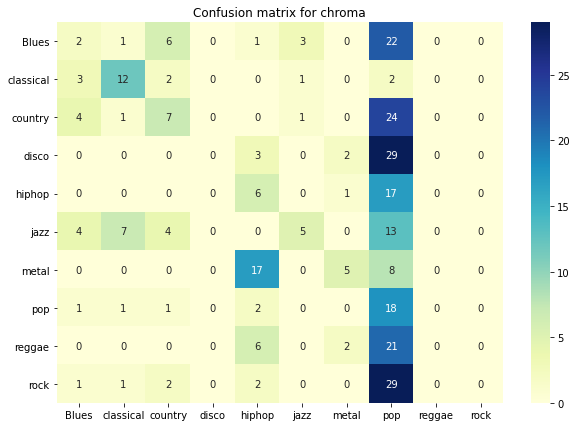

In [ ]:
# train the model with SVM using Polynomial kernal
svm_model(poly_params, chromaX_train, chromaY_train.ravel(), chromaX_test, chromaY_test, "Confusion matrix for chroma")

In [ ]:
# train the model with KNN
model_chroma = KNeighborsClassifier(n_neighbors=3)
model_chroma.fit(chromaX_train, chromaY_train)
model_chroma_pred = model_chroma.predict(chromaX_test)

train_accuracy = model_chroma.score(chromaX_train, chromaY_train)
test_accuracy = accuracy_score(chromaY_test, model_chroma_pred)
print("Train set accuracy: {:.2f}".format(train_accuracy))
print("Test set accuracy: {:.2f}".format(test_accuracy))

Train set accuracy: 0.53
Test set accuracy: 0.23


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


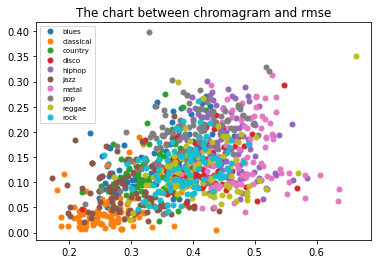

In [ ]:
groups = data.groupby('label')

# Plot the chromagram
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.chroma_stft, group.rmse, marker='o', linestyle='', ms=5, label=name)
ax.legend(prop=dict(size=7))
plt.title("The chart between chromagram and rmse")

plt.show()

## MFCCS

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train set accuracy: 0.59
Test set accuracy = 0.47333333333333333


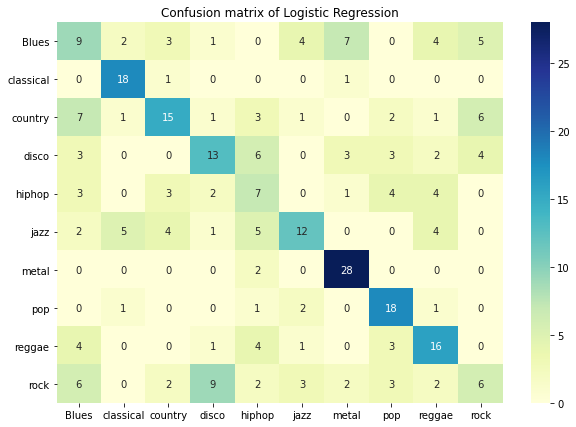

In [ ]:
#traing the model using only Chroma as feature
mfccs = scaler.fit_transform(np.array(data.iloc[:,9:-1]))
mfccsX_train, mfccsX_test, mfccsY_train, mfccsY_test = train_test_split(mfccs, y.reshape(-1,1), test_size=0.30, random_state=42)
log_reg_func(mfccsX_train, mfccsY_train, mfccsX_test, mfccsY_test, ["Blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"])

Train set accuracy: 0.55
Test set accuracy: 0.41


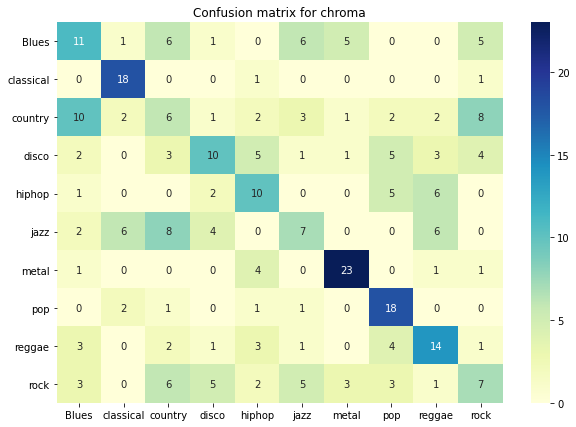

In [ ]:
# train the model with SVM using Linear kernal
svm_model(linear_params, mfccsX_train, mfccsY_train.ravel(), mfccsX_test, mfccsY_test, "Confusion matrix for chroma")

Train set accuracy: 0.66
Test set accuracy: 0.49


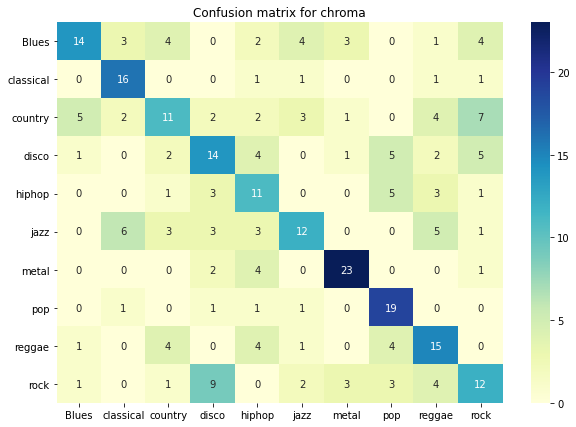

In [ ]:
# train the model with SVM using RBF kernal
svm_model(rbf_params, mfccsX_train, mfccsY_train.ravel(), mfccsX_test, mfccsY_test, "Confusion matrix for chroma")

Train set accuracy: 0.69
Test set accuracy: 0.45


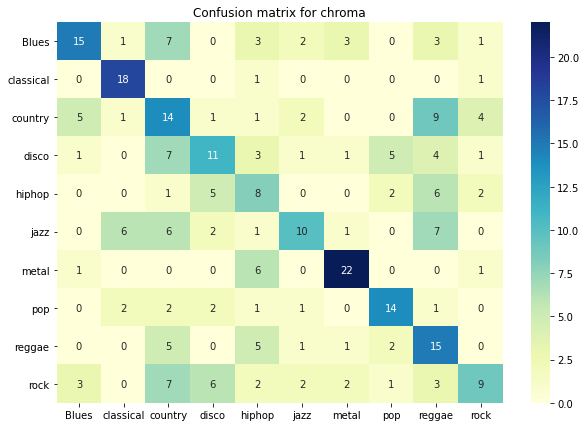

In [ ]:
# train the model with SVM using Polynomial kernal
svm_model(poly_params, mfccsX_train, mfccsY_train.ravel(), mfccsX_test, mfccsY_test, "Confusion matrix for chroma")

In [ ]:
# train the model with KNN
model_mfccs = KNeighborsClassifier(n_neighbors=3)
model_mfccs.fit(mfccsX_train, mfccsY_train)
model_mfccs_pred = model_mfccs.predict(mfccsX_test)

train_accuracy = model_mfccs.score(mfccsX_train, mfccsY_train)
test_accuracy = accuracy_score(mfccsY_test, model_mfccs_pred)
print("Train set accuracy: {:.2f}".format(train_accuracy))
print("Test set accuracy: {:.2f}".format(test_accuracy))

Train set accuracy: 0.77
Test set accuracy: 0.53


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


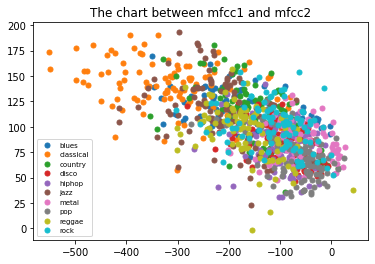

In [ ]:
groups = data.groupby('label')

# Plot the chromagram
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.mfcc1, group.mfcc2, marker='o', linestyle='', ms=5, label=name)
ax.legend(prop=dict(size=7))
plt.title("The chart between mfcc1 and mfcc2")
plt.show()